# Projeto: Detecção de Pneumonia via Raios-X de Tórax (CNN)

## Introdução
O objetivo deste projeto é desenvolver um modelo de Deep Learning baseado em Redes Neurais Convolucionais (CNN) para automatizar a detecção de pneumonia em imagens de Raios-X de tórax. O projeto abrange desde a análise exploratória até o deploy em um container Docker.

### Dataset
O conjunto de dados é composto por imagens de Raios-X de tórax (anterior-posterior) selecionadas de coortes retrospectivas de pacientes pediátricos. As imagens são divididas em duas classes: **Normal** e **Pneumonia**.

---

## Análise da Distribuição das Classes
Nesta etapa, verificamos a quantidade de amostras disponíveis em cada conjunto (Treino, Teste e Validação).

In [1]:
import os
import pandas as pd

base_path = '../data'
sets = ['train', 'val', 'test']
categories = ['NORMAL', 'PNEUMONIA']

data = []

for s in sets:
    for cat in categories:
        path = os.path.join(base_path, s, cat)
        count = len(os.listdir(path))
        data.append([s, cat, count])

df_counts = pd.DataFrame(data, columns=['Dataset', 'Classe', 'Total'])
print(df_counts)

# Pivot para melhor visualização
print(df_counts.pivot(index='Dataset', columns='Classe', values='Total'))

  Dataset     Classe  Total
0   train     NORMAL   1342
1   train  PNEUMONIA   3876
2     val     NORMAL      9
3     val  PNEUMONIA      9
4    test     NORMAL    234
5    test  PNEUMONIA    390
Classe   NORMAL  PNEUMONIA
Dataset                   
test        234        390
train      1342       3876
val           9          9


### Observações:
* **Desbalanceamento:** O conjunto de treino apresenta um desbalanceamento significativo (Pneumonia >> Normal).
* **Estratégia:** Durante o treinamento, deveremos considerar o uso de **Pesos de Classe (Class Weights)** ou técnicas de **Data Augmentation** para evitar que o modelo se torne tendencioso para a classe majoritária.

## Visualização de Imagens
Nesta etapa, carregamos amostras aleatórias de pulmões "Normais" e com "Pneumonia".

Amostras de imagens NORMAL:


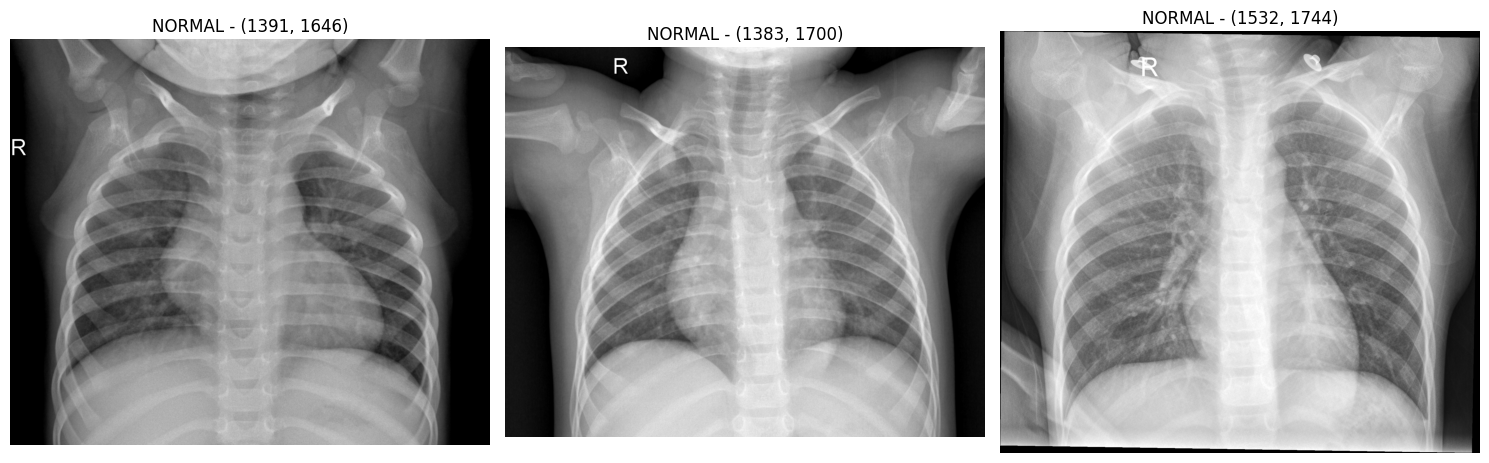

Amostras de imagens PNEUMONIA:


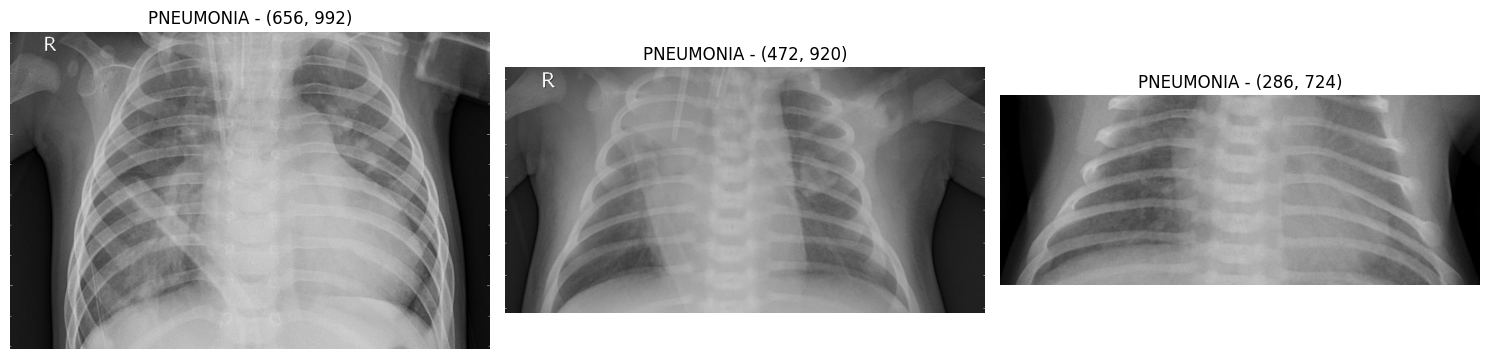

In [2]:
import cv2
import random
import matplotlib.pyplot as plt

def plot_samples(base_path, category):
    folder = os.path.join(base_path, 'train', category)
    img_names = random.sample(os.listdir(folder), 3)

    plt.figure(figsize=(15,5))
    for i, name in enumerate(img_names):
        img_path = os.path.join(folder, name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f'{category} - {img.shape[:2]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Amostras de imagens NORMAL:")
plot_samples(base_path, 'NORMAL')

print("Amostras de imagens PNEUMONIA:")
plot_samples(base_path, 'PNEUMONIA')

## Preparação dos Dados (Data Augmentation)
Nesta etapa, padronizamos o tamanho das imagens para **224x224** e aplicamos transformações aleatórias (rotação, zoom, inversão horizontal) no conjunto de treino.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configurações globais
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Gerador para treino com Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Gerador para validação e teste sem Data Augmentation
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Carregando as imagens dos diretórios
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=42,                  # Adicionado para replicação
    interpolation='bilinear'
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    interpolation='bilinear'
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    interpolation='bilinear'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Construção do Modelo
Utilizaremos a arquitetura **MobileNetV2** pré-treinada na ImageNet como base. Congelaremos as camadas iniciais para aproveitar os extratores de características já aprendidos e adicionaremos uma cabeça de classificação customizada para o nosso problema.

In [4]:
# Garantindo a reprodutibilidade dos resultados

import random
import numpy as np
import tensorflow as tf

def set_reproducibility(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"Semente {seed} fixada para garantir a replicação dos resultados.")

set_reproducibility(42)

Semente 42 fixada para garantir a replicação dos resultados.


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Carregar o modelo pré-treinado MobileNetV2
base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')

# Congelar as camadas do modelo base
base_model.trainable = False

# Construir o modelo completo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Tratamento de Desbalanceamento (Class Weights)
Como o dataset possui muito mais exemplos de pneumonia do que normais, o modelo pode aprender que "chutar" sempre pneumonia garante uma boa acurácia. Para evitar isso, calculamos pesos que dão mais importância para a classe minoritária (NORMAL) durante o ajuste dos gradientes.

In [6]:
# Contagem obtida na EDA
count_normal = 1341
count_pneumonia = 3875
total = count_normal + count_pneumonia

# Cálculo de pesos para classes desbalanceadas
weight_for_0 = (1 / count_normal) * (total / 2.0)
weight_for_1 = (1 / count_pneumonia) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Peso para classe NORMAL (0): {weight_for_0:.4f}")
print(f"Peso para classe PNEUMONIA (1): {weight_for_1:.4f}")

Peso para classe NORMAL (0): 1.9448
Peso para classe PNEUMONIA (1): 0.6730


## Treinamento do Modelo
Configuramos o treinamento com 10 épocas inicialmente. Utilizamos `EarlyStopping` para evitar overfitting e `ModelCheckpoint` para garantir que salvaremos apenas a melhor versão do modelo na pasta `models/`.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definindo callbacks para o treinamento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('../models/best_model.keras', save_best_only=True)
]

# Treinando o modelo
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks   
)



Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - Precision: 0.9524 - Recall: 0.8514 - accuracy: 0.8579 - loss: 0.3241 - val_Precision: 1.0000 - val_Recall: 0.7500 - val_accuracy: 0.8750 - val_loss: 0.2836
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - Precision: 0.9756 - Recall: 0.8986 - accuracy: 0.9080 - loss: 0.2088 - val_Precision: 1.0000 - val_Recall: 0.7500 - val_accuracy: 0.8750 - val_loss: 0.2374
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - Precision: 0.9803 - Recall: 0.9128 - accuracy: 0.9216 - loss: 0.1833 - val_Precision: 1.0000 - val_Recall: 0.6250 - val_accuracy: 0.8125 - val_loss: 0.2869
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - Precision: 0.9813 - Recall: 0.9226 - accuracy: 0.9294 - loss: 0.1697 - val_Precision: 1.0000 - val_Recall: 0.7500 - val_accuracy: 0.8750 - val_loss: 0.2441
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - Precision: 0.9817 - Recall: 0.9280 - accuracy: 0.9337 - loss: 0.1674 - val_Precision: 1.0000 - val_Re

## Avaliação do Aprendizado

Geramos os gráficos de Perda (Loss) e Acurácia (Accuracy) para verificar a convergência do modelo. O ideal é que as curvas de treino e validação caminhem juntas.

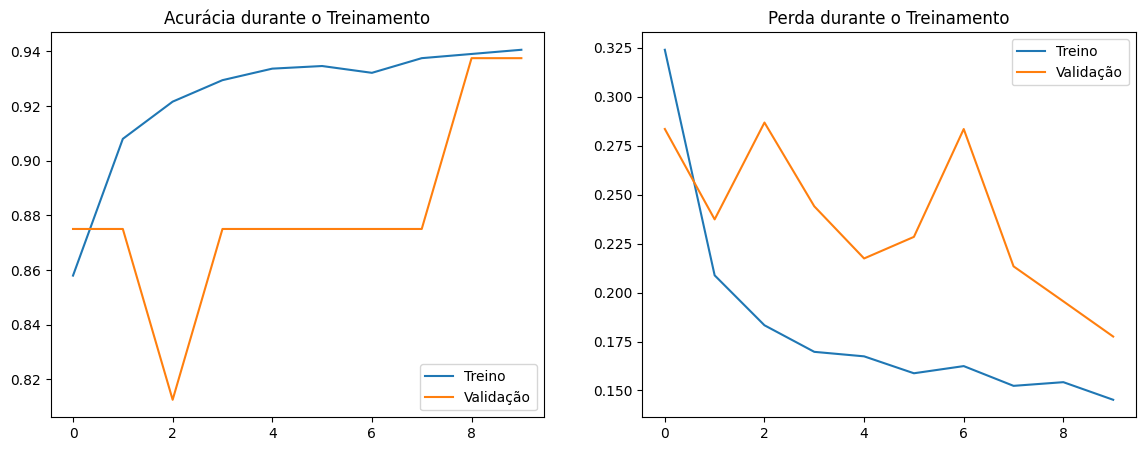

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14,5))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Treino')
    plt.plot(epochs_range, val_acc, label='Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia durante o Treinamento')

    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Treino')
    plt.plot(epochs_range, val_loss, label='Validação')
    plt.legend(loc='upper right')
    plt.title('Perda durante o Treinamento')

    plt.show()

plot_history(history)

## Matriz de Confusão e Métricas Detalhadas
A matriz de confusão nos mostra exatamente onde o modelo está confundindo as classes. Para o diagnóstico médico, o **Recall** da classe Pneumonia é crítico: queremos minimizar ao máximo os casos em que o modelo diz "Normal" para um paciente doente.

20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step


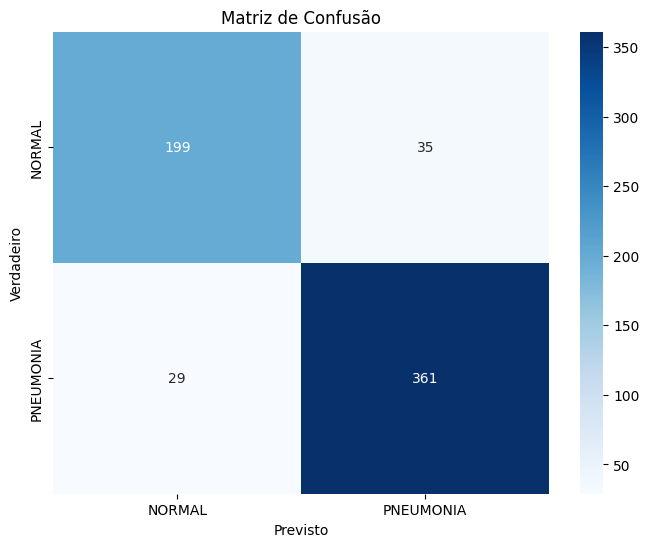

Relatório de Classificação:
               precision    recall  f1-score   support

      NORMAL       0.87      0.85      0.86       234
   PNEUMONIA       0.91      0.93      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Gerando previsões no conjunto de teste
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes

# Gerando a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()

# Relatório de classificação
report = classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print("Relatório de Classificação:\n", report)